In [ ]:
# Cell 1: Install required packages
# Note: This cell installs necessary libraries for the analysis.
# In environments where installation is not allowed, assume they are pre-installed.
!pip install xgboost pandas numpy matplotlib seaborn scikit-learn ipywidgets kaggle imbalanced-learn statsmodels

In [ ]:
# Cell 2: Import necessary libraries
# This cell imports all required modules for data processing, modeling, visualization, and interactive widgets.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
import xgboost as xgb
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
from google.colab import files
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency, ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline

In [ ]:
# Cell 3: Upload Kaggle API credentials
# This cell prompts the user to upload the kaggle.json file for authentication.
print("Please upload your kaggle.json file.")
uploaded = files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Please upload your kaggle.json file.


Saving kaggle.json to kaggle.json


In [ ]:
# Cell 4: Download and unzip the dataset
# This cell downloads the credit risk dataset from Kaggle and unzips it.
!kaggle datasets download -d laotse/credit-risk-dataset --force
!unzip -o credit-risk-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/laotse/credit-risk-dataset
License(s): CC0-1.0
  0% 0.00/368k [00:00<?, ?B/s]
100% 368k/368k [00:00<00:00, 789MB/s]
Archive:  credit-risk-dataset.zip
  inflating: credit_risk_dataset.csv  


In [ ]:
# Cell 5: Load the dataset and display head
# This cell loads the CSV file into a DataFrame and prints the first few rows for inspection.
df = pd.read_csv('credit_risk_dataset.csv')
print("Dataset loaded successfully.")
print("First 5 rows of the dataset:")
display(df.head())

Dataset loaded successfully.
First 5 rows of the dataset:


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [ ]:
# Cell 6: Handle missing values
# This cell imputes missing values in 'person_emp_length' and 'loan_int_rate' using mean strategy.
imputer = SimpleImputer(strategy='mean')
df['person_emp_length'] = imputer.fit_transform(df[['person_emp_length']])
df['loan_int_rate'] = imputer.fit_transform(df[['loan_int_rate']])
print("Missing values imputed successfully.")
print("Updated DataFrame info:")
df.info()

Missing values imputed successfully.
Updated DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           32581 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               32581 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), ob

In [ ]:
# Cell 7: Encode categorical variables
# This cell encodes categorical columns using LabelEncoder and stores the encoders for later use.
label_encoders = {}
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
print("Categorical variables encoded.")
print("Unique values after encoding:")
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")

Categorical variables encoded.
Unique values after encoding:
person_home_ownership: [3 2 0 1]
loan_intent: [4 1 3 5 2 0]
loan_grade: [3 1 2 0 4 5 6]
cb_person_default_on_file: [1 0]


In [ ]:
# Cell 8: Feature engineering - Remove outliers
# This cell removes rows where 'person_age' > 100, assuming they are outliers.
df = df[df['person_age'] <= 100]
print("Outliers removed from 'person_age'.")
print(f"Updated DataFrame shape: {df.shape}")

Outliers removed from 'person_age'.
Updated DataFrame shape: (32576, 12)


In [ ]:
# Cell 9: Split features and target, scale numerical features
# This cell separates features (X) and target (y), scales numerical columns.
X = df.drop('loan_status', axis=1)
y = df['loan_status']
scaler = StandardScaler()
numerical_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
print("Features scaled.")
print("Sample scaled features:")
display(X.head())

Features scaled.
Sample scaled features:


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,-0.921538,-0.131003,3,28.935309,4,3,4.019571,1.625198,3.931479,1,-0.691701
1,-1.082701,-1.071343,2,0.051518,1,1,-1.358653,0.041677,-0.657567,0,-0.938387
2,-0.438048,-1.071343,0,-0.927593,3,2,-0.646829,0.603049,3.744171,0,-0.691701
3,-0.760375,-0.007274,3,-0.193260,3,2,4.019571,1.368850,3.369555,0,-0.938387
4,-0.599211,-0.218565,3,0.785852,3,2,4.019571,1.057337,3.556863,1,-0.445014


In [ ]:
# Cell 10: Split data into train and test sets
# This cell splits the data into training and testing sets (80/20 split).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Data split into train and test.")
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Data split into train and test.
Train shape: (26060, 11), Test shape: (6516, 11)


In [ ]:
# Cell 11: Display summary statistics
# This cell prints descriptive statistics for the DataFrame.
print("Summary statistics of the dataset:")
display(df.describe())

Summary statistics of the dataset:


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
count,32576.000000,3.257600e+04,32576.000000,32576.000000,32576.000000,32576.000000,32576.000000,32576.000000,32576.000000,32576.000000,32576.000000,32576.000000
mean,27.718044,6.588214e+04,1.676203,4.789531,2.533736,1.218167,9589.117755,11.011561,0.218197,0.170212,0.176357,5.803966
std,6.204990,5.253499e+04,1.433109,4.085399,1.731146,1.166407,6321.886846,3.081787,0.413029,0.106778,0.381129,4.053791
min,20.000000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,500.000000,5.420000,0.000000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,0.000000,2.000000,1.000000,0.000000,5000.000000,8.490000,0.000000,0.090000,0.000000,3.000000
50%,26.000000,5.500000e+04,3.000000,4.000000,3.000000,1.000000,8000.000000,11.011695,0.000000,0.150000,0.000000,4.000000
75%,30.000000,7.920000e+04,3.000000,7.000000,4.000000,2.000000,12200.000000,13.110000,0.000000,0.230000,0.000000,8.000000
max,94.000000,2.039784e+06,3.000000,123.000000,5.000000,6.000000,35000.000000,23.220000,1.000000,0.830000,1.000000,30.000000


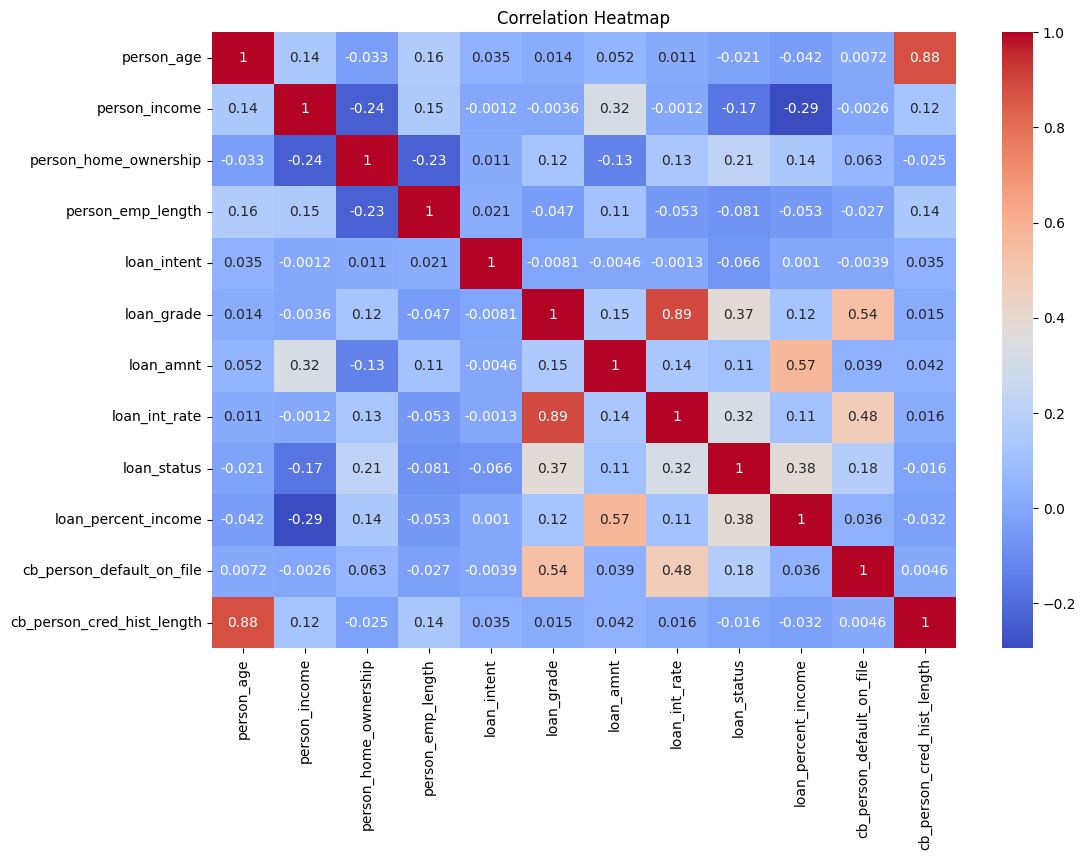

Correlation heatmap displayed.


In [ ]:
# Cell 12: Plot correlation heatmap
# This cell generates and displays a correlation heatmap for the DataFrame.
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()
print("Correlation heatmap displayed.")

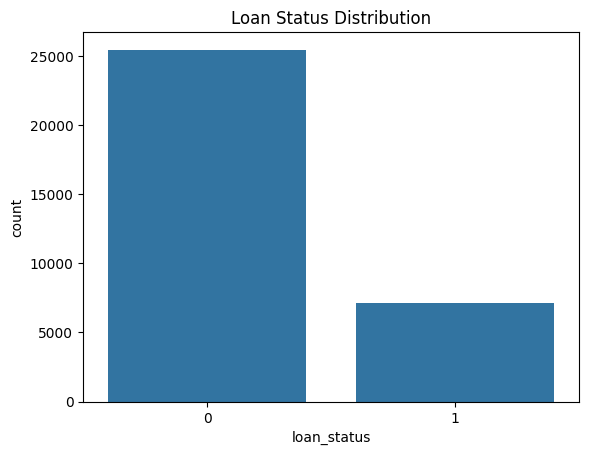

Loan status distribution plot displayed.


In [ ]:
# Cell 13: Plot distribution of target variable
# This cell creates a countplot for the 'loan_status' distribution.
sns.countplot(x='loan_status', data=df)
plt.title('Loan Status Distribution')
plt.show()
print("Loan status distribution plot displayed.")

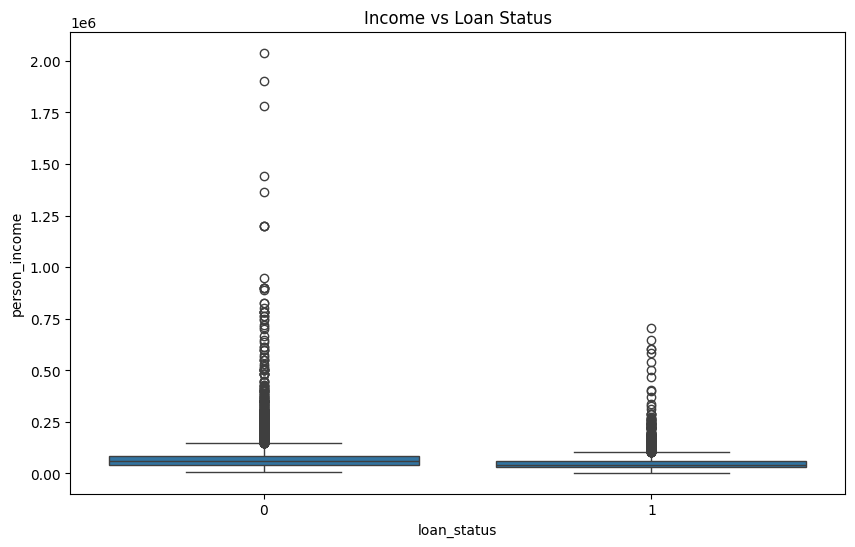

Income vs loan status boxplot displayed.


In [ ]:
# Cell 14: Plot boxplot for income vs loan status
# This cell generates a boxplot comparing 'person_income' across 'loan_status'.
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='person_income', data=df)
plt.title('Income vs Loan Status')
plt.show()
print("Income vs loan status boxplot displayed.")

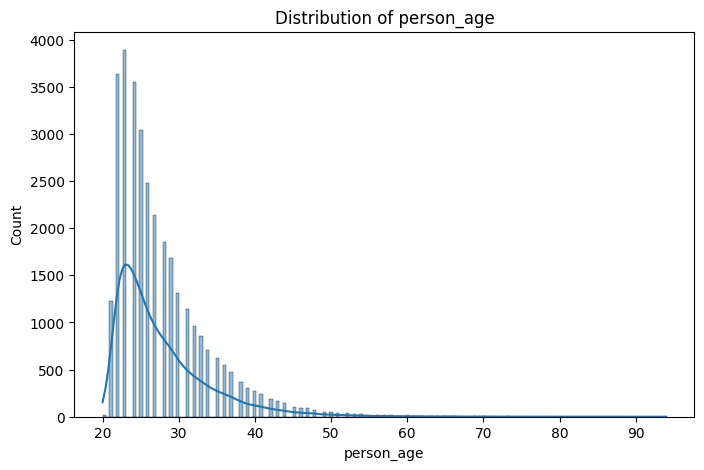

Distribution of person_age displayed.


In [ ]:
# Cell 15: Plot distribution of person_age
# This cell plots the histogram and KDE for 'person_age'.
plt.figure(figsize=(8, 5))
sns.histplot(df['person_age'], kde=True)
plt.title('Distribution of person_age')
plt.show()
print("Distribution of person_age displayed.")

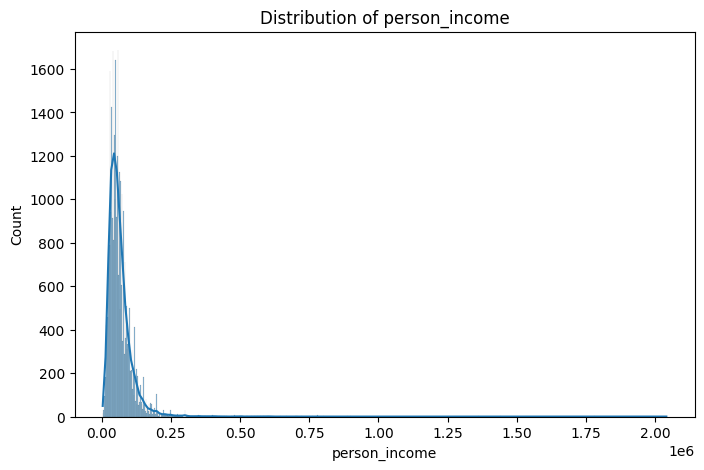

Distribution of person_income displayed.


In [ ]:
# Cell 16: Plot distribution of person_income
# This cell plots the histogram and KDE for 'person_income'.
plt.figure(figsize=(8, 5))
sns.histplot(df['person_income'], kde=True)
plt.title('Distribution of person_income')
plt.show()
print("Distribution of person_income displayed.")

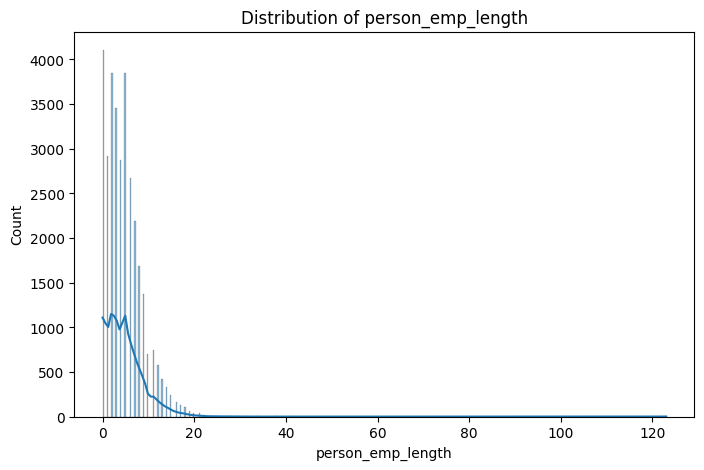

Distribution of person_emp_length displayed.


In [ ]:
# Cell 17: Plot distribution of person_emp_length
# This cell plots the histogram and KDE for 'person_emp_length'.
plt.figure(figsize=(8, 5))
sns.histplot(df['person_emp_length'], kde=True)
plt.title('Distribution of person_emp_length')
plt.show()
print("Distribution of person_emp_length displayed.")

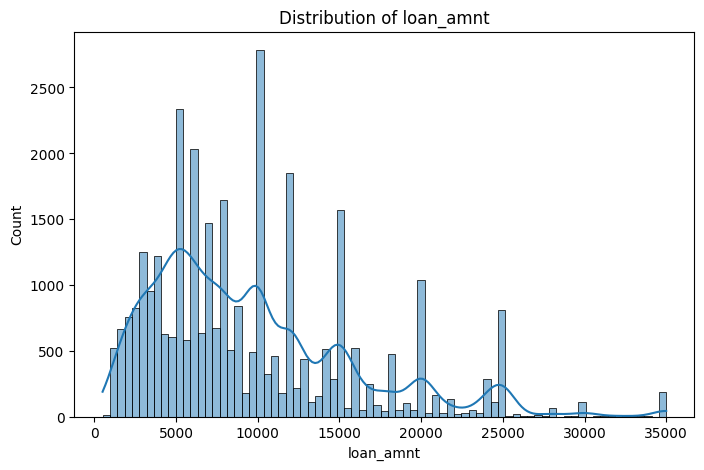

Distribution of loan_amnt displayed.


In [ ]:
# Cell 18: Plot distribution of loan_amnt
# This cell plots the histogram and KDE for 'loan_amnt'.
plt.figure(figsize=(8, 5))
sns.histplot(df['loan_amnt'], kde=True)
plt.title('Distribution of loan_amnt')
plt.show()
print("Distribution of loan_amnt displayed.")

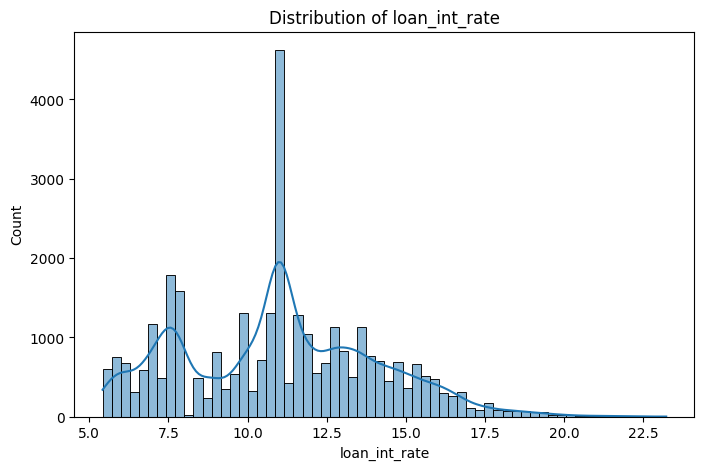

Distribution of loan_int_rate displayed.


In [ ]:
# Cell 19: Plot distribution of loan_int_rate
# This cell plots the histogram and KDE for 'loan_int_rate'.
plt.figure(figsize=(8, 5))
sns.histplot(df['loan_int_rate'], kde=True)
plt.title('Distribution of loan_int_rate')
plt.show()
print("Distribution of loan_int_rate displayed.")

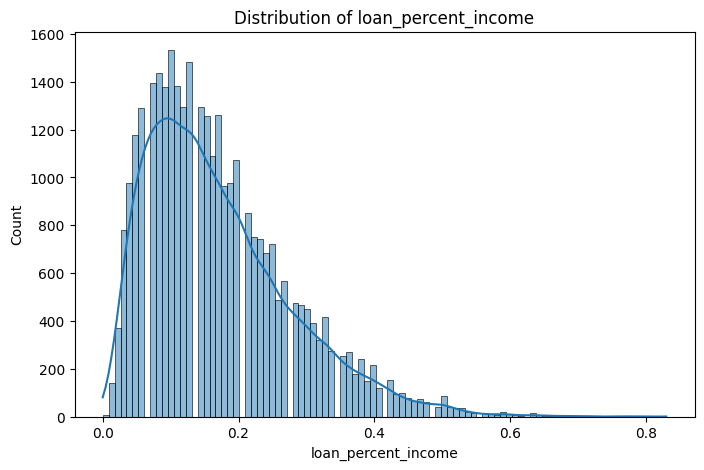

Distribution of loan_percent_income displayed.


In [ ]:
# Cell 20: Plot distribution of loan_percent_income
# This cell plots the histogram and KDE for 'loan_percent_income'.
plt.figure(figsize=(8, 5))
sns.histplot(df['loan_percent_income'], kde=True)
plt.title('Distribution of loan_percent_income')
plt.show()
print("Distribution of loan_percent_income displayed.")

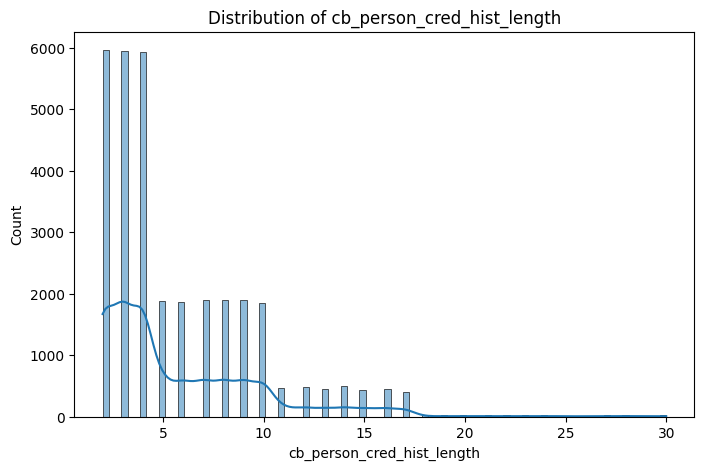

Distribution of cb_person_cred_hist_length displayed.


In [ ]:
# Cell 21: Plot distribution of cb_person_cred_hist_length
# This cell plots the histogram and KDE for 'cb_person_cred_hist_length'.
plt.figure(figsize=(8, 5))
sns.histplot(df['cb_person_cred_hist_length'], kde=True)
plt.title('Distribution of cb_person_cred_hist_length')
plt.show()
print("Distribution of cb_person_cred_hist_length displayed.")

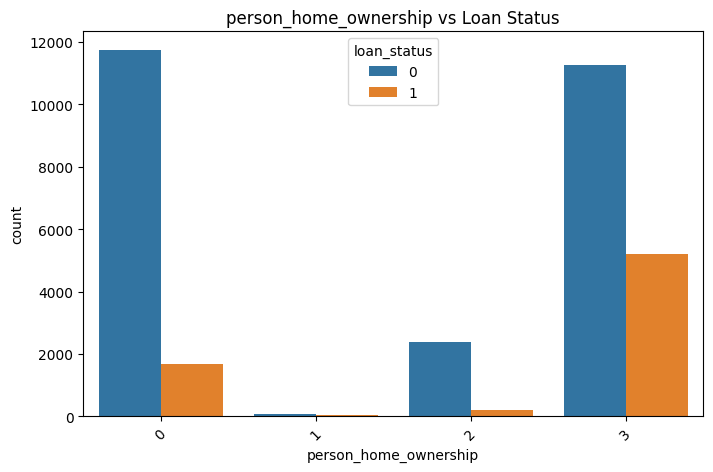

person_home_ownership vs loan_status plot displayed.


In [ ]:
# Cell 22: Plot countplot for person_home_ownership vs loan_status
# This cell creates a countplot for 'person_home_ownership' grouped by 'loan_status'.
plt.figure(figsize=(8, 5))
sns.countplot(x='person_home_ownership', hue='loan_status', data=df)
plt.title('person_home_ownership vs Loan Status')
plt.xticks(rotation=45)
plt.show()
print("person_home_ownership vs loan_status plot displayed.")

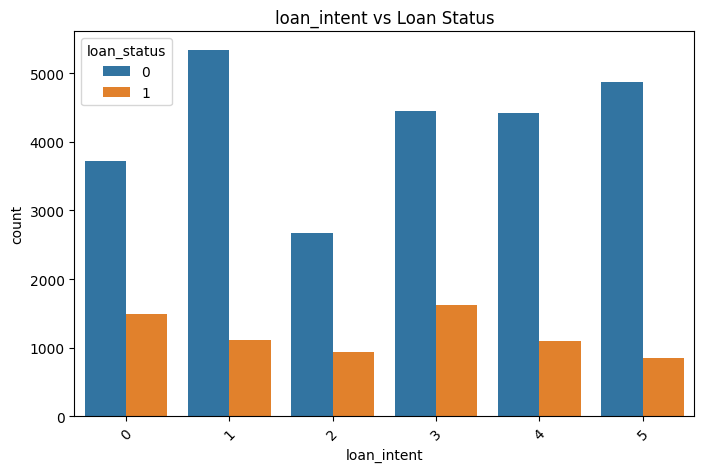

loan_intent vs loan_status plot displayed.


In [ ]:
# Cell 23: Plot countplot for loan_intent vs loan_status
# This cell creates a countplot for 'loan_intent' grouped by 'loan_status'.
plt.figure(figsize=(8, 5))
sns.countplot(x='loan_intent', hue='loan_status', data=df)
plt.title('loan_intent vs Loan Status')
plt.xticks(rotation=45)
plt.show()
print("loan_intent vs loan_status plot displayed.")

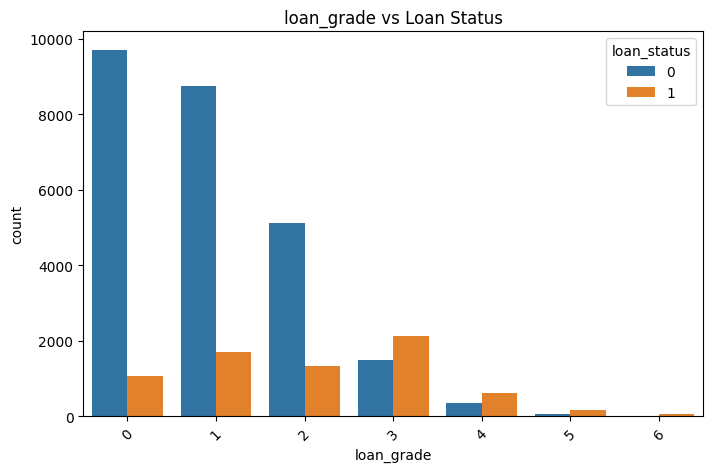

loan_grade vs loan_status plot displayed.


In [ ]:
# Cell 24: Plot countplot for loan_grade vs loan_status
# This cell creates a countplot for 'loan_grade' grouped by 'loan_status'.
plt.figure(figsize=(8, 5))
sns.countplot(x='loan_grade', hue='loan_status', data=df)
plt.title('loan_grade vs Loan Status')
plt.xticks(rotation=45)
plt.show()
print("loan_grade vs loan_status plot displayed.")

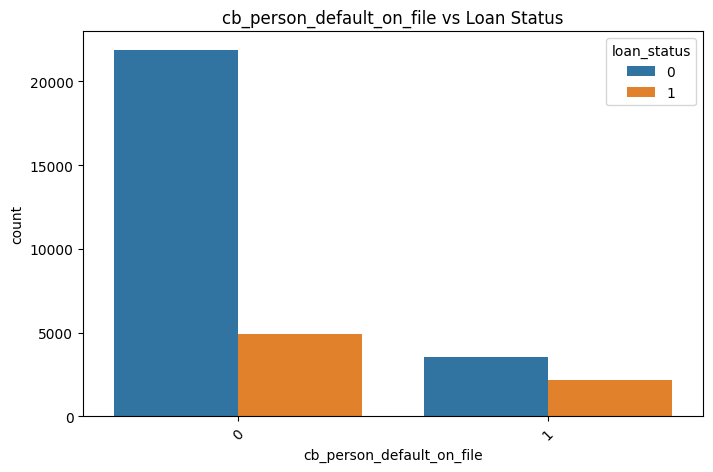

cb_person_default_on_file vs loan_status plot displayed.


In [ ]:
# Cell 25: Plot countplot for cb_person_default_on_file vs loan_status
# This cell creates a countplot for 'cb_person_default_on_file' grouped by 'loan_status'.
plt.figure(figsize=(8, 5))
sns.countplot(x='cb_person_default_on_file', hue='loan_status', data=df)
plt.title('cb_person_default_on_file vs Loan Status')
plt.xticks(rotation=45)
plt.show()
print("cb_person_default_on_file vs loan_status plot displayed.")

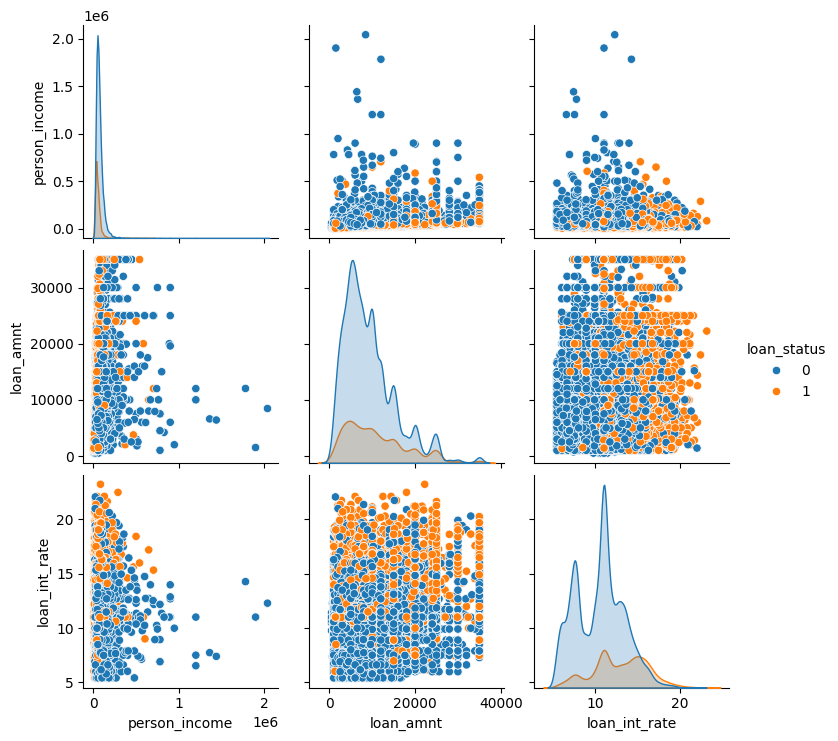

Pairplot displayed.


In [ ]:
# Cell 26: Plot pairplot for key features
# This cell generates a pairplot for selected features colored by 'loan_status'.
sns.pairplot(df[['person_income', 'loan_amnt', 'loan_int_rate', 'loan_status']], hue='loan_status')
plt.show()
print("Pairplot displayed.")

In [ ]:
# Cell 27: Perform chi-square tests for categorical features
# This cell computes and prints chi-square p-values for categorical features vs 'loan_status'.
for col in categorical_cols:
    contingency = pd.crosstab(df[col], df['loan_status'])
    chi2, p, _, _ = chi2_contingency(contingency)
    print(f'{col} Chi-square p-value: {p}')

person_home_ownership Chi-square p-value: 0.0
loan_intent Chi-square p-value: 4.048773674352431e-110
loan_grade Chi-square p-value: 0.0
cb_person_default_on_file Chi-square p-value: 5.10125812727606e-229


In [ ]:
# Cell 28: Perform t-tests for numerical features
# This cell computes and prints t-test p-values for numerical features vs 'loan_status'.
for col in numerical_cols:
    group0 = df[df['loan_status'] == 0][col]
    group1 = df[df['loan_status'] == 1][col]
    t_stat, p = ttest_ind(group0, group1)
    print(f'{col} T-test p-value: {p}')

person_age T-test p-value: 0.00018394596914150669
person_income T-test p-value: 4.647904061917976e-206
person_emp_length T-test p-value: 1.6442299231426066e-48
loan_amnt T-test p-value: 3.8620187282029397e-81
loan_int_rate T-test p-value: 0.0
loan_percent_income T-test p-value: 0.0
cb_person_cred_hist_length T-test p-value: 0.005137375140764368


In [ ]:
# Cell 29: Calculate Variance Inflation Factor (VIF)
# This cell computes VIF for numerical features and prints the results.
X_num = df[numerical_cols]
vif_data = pd.DataFrame()
vif_data['feature'] = X_num.columns
vif_data['VIF'] = [variance_inflation_factor(X_num.values, i) for i in range(len(X_num.columns))]
print("VIF for numerical features:")
display(vif_data)

VIF for numerical features:


,feature,VIF
0,person_age,30.275762
1,person_income,4.487300
2,person_emp_length,2.507052
3,loan_amnt,8.030369
4,loan_int_rate,11.548607
5,loan_percent_income,8.033683
6,cb_person_cred_hist_length,7.651631


In [ ]:
# Cell 30: Hyperparameter tuning with GridSearchCV
# This cell performs grid search for XGBoost hyperparameters using ROC AUC scoring.
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc')
param_grid = {
    'max_depth': [4, 6, 8],
    'eta': [0.1, 0.3, 0.5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best params:', grid_search.best_params_)
best_params = grid_search.best_params_

Best params: {'colsample_bytree': 0.8, 'eta': 0.1, 'max_depth': 8, 'subsample': 0.9}


In [ ]:
# Cell 31: Handle class imbalance with SMOTE
# This cell applies SMOTE oversampling to the training data.
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("SMOTE applied.")
print(f"Resampled train shape: {X_train_res.shape}")

SMOTE applied.
Resampled train shape: (40744, 11)


In [ ]:
# Cell 32: Train XGBoost model with resampled data
# This cell trains the XGBoost model using the best parameters and resampled data.
dtrain_res = xgb.DMatrix(X_train_res, label=y_train_res)
dtest = xgb.DMatrix(X_test, label=y_test)
model = xgb.train(best_params, dtrain_res, num_boost_round=100, evals=[(dtest, 'test')], early_stopping_rounds=10)
print("XGBoost model trained.")

[0]	test-rmse:0.47424
[1]	test-rmse:0.45122
[2]	test-rmse:0.43622
[3]	test-rmse:0.41866
[4]	test-rmse:0.40066
[5]	test-rmse:0.38638
[6]	test-rmse:0.37480
[7]	test-rmse:0.36402
[8]	test-rmse:0.35435
[9]	test-rmse:0.34349
[10]	test-rmse:0.33614
[11]	test-rmse:0.33075
[12]	test-rmse:0.32521
[13]	test-rmse:0.31863
[14]	test-rmse:0.31278
[15]	test-rmse:0.30827
[16]	test-rmse:0.30424
[17]	test-rmse:0.30108
[18]	test-rmse:0.29774
[19]	test-rmse:0.29488
[20]	test-rmse:0.29183
[21]	test-rmse:0.28930
[22]	test-rmse:0.28702
[23]	test-rmse:0.28524
[24]	test-rmse:0.28246
[25]	test-rmse:0.28074
[26]	test-rmse:0.27972
[27]	test-rmse:0.27855
[28]	test-rmse:0.27776
[29]	test-rmse:0.27668
[30]	test-rmse:0.27542
[31]	test-rmse:0.27423
[32]	test-rmse:0.27356
[33]	test-rmse:0.27261
[34]	test-rmse:0.27152
[35]	test-rmse:0.27070
[36]	test-rmse:0.27021
[37]	test-rmse:0.26947
[38]	test-rmse:0.26898
[39]	test-rmse:0.26831
[40]	test-rmse:0.26785
[41]	test-rmse:0.26736
[42]	test-rmse:0.26698
[43]	test-rmse:0.2663

In [ ]:
# Cell 33: Train and evaluate Logistic Regression
# This cell trains a logistic regression model and prints its AUC on test data.
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_res, y_train_res)
y_pred_lr_prob = lr.predict_proba(X_test)[:, 1]
print('Logistic Regression AUC:', roc_auc_score(y_test, y_pred_lr_prob))

Logistic Regression AUC: 0.8461577155239126


In [ ]:
# Cell 34: Train and evaluate Random Forest
# This cell trains a random forest model and prints its AUC on test data.
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res, y_train_res)
y_pred_rf_prob = rf.predict_proba(X_test)[:, 1]
print('Random Forest AUC:', roc_auc_score(y_test, y_pred_rf_prob))

Random Forest AUC: 0.9273294298759591


In [ ]:
# Cell 35: Cross-validation scores for best XGBoost
# This cell computes and prints the mean CV AUC for the best XGBoost estimator.
cv_scores = cross_val_score(grid_search.best_estimator_, X, y, cv=5, scoring='roc_auc')
print('CV AUC Mean:', cv_scores.mean())

CV AUC Mean: 0.9149578737388129


In [ ]:
# Cell 36: Make predictions with XGBoost and evaluate
# This cell generates predictions, prints classification report and AUC.
y_pred_prob = model.predict(dtest)
y_pred = (y_pred_prob > 0.5).astype(int)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print('AUC:', roc_auc_score(y_test, y_pred_prob))

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5096
           1       0.94      0.72      0.81      1420

    accuracy                           0.93      6516
   macro avg       0.93      0.85      0.88      6516
weighted avg       0.93      0.93      0.92      6516

AUC: 0.9339982200897694


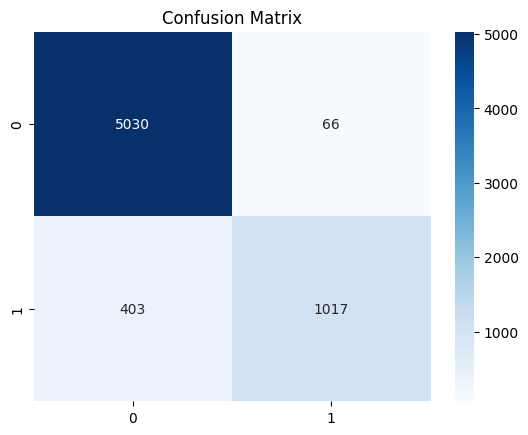

Confusion matrix displayed.


In [ ]:
# Cell 37: Plot confusion matrix
# This cell generates and displays the confusion matrix heatmap.
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
print("Confusion matrix displayed.")

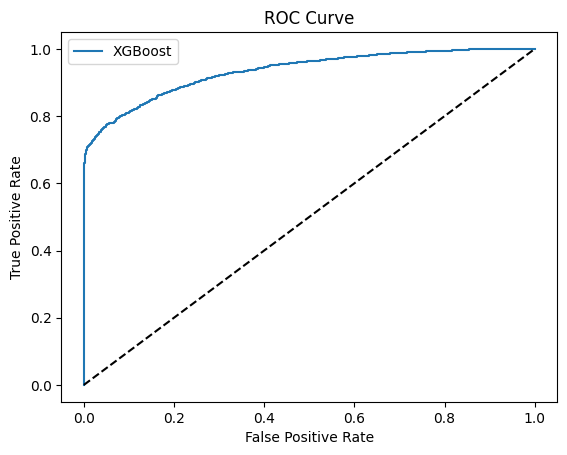

ROC curve displayed.


In [ ]:
# Cell 38: Plot ROC curve
# This cell plots the ROC curve for the XGBoost model.
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label='XGBoost')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
print("ROC curve displayed.")

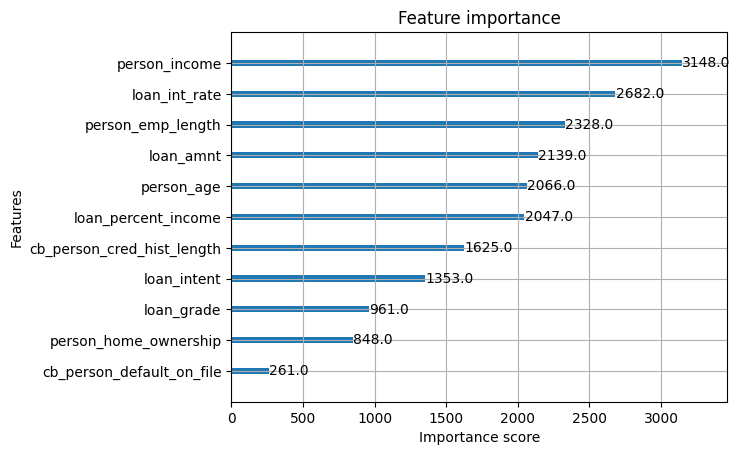

Feature importance plot displayed.


In [ ]:
# Cell 39: Plot feature importance
# This cell displays the feature importance from the XGBoost model.
xgb.plot_importance(model)
plt.show()
print("Feature importance plot displayed.")

In [ ]:
# Cell 40: Define interactive widgets for prediction
# This cell sets up the ipywidgets for the credit approval checker interface.
from ipywidgets import Layout, VBox, HBox, Label, HTML, ButtonStyle, IntText, FloatText, Dropdown
# Define layouts for consistency
label_layout = Layout(width='200px', display='flex', justify_content='flex-end', padding='0 10px 0 0')
input_layout = Layout(width='300px')
row_layout = Layout(display='flex', flex_flow='row', align_items='center', width='100%')
form_layout = Layout(display='flex', flex_flow='column', border='solid 1px lightgray', padding='20px', width='600px', margin='0 auto')
section_header_style = 'background-color: #f0f0f0; padding: 5px; font-weight: bold;'
# Create widgets without built-in descriptions
age = IntText(value=30, layout=input_layout)
income = IntText(value=60000, layout=input_layout)
home_ownership = Dropdown(options=['RENT', 'OWN', 'MORTGAGE', 'OTHER'], value='RENT', layout=input_layout)
emp_length = FloatText(value=5.0, layout=input_layout)
loan_intent = Dropdown(options=['PERSONAL', 'EDUCATION', 'MEDICAL', 'VENTURE', 'HOMEIMPROVEMENT', 'DEBTCONSOLIDATION'], value='PERSONAL', layout=input_layout)
loan_grade = Dropdown(options=['A', 'B', 'C', 'D', 'E', 'F', 'G'], value='A', layout=input_layout)
loan_amnt = IntText(value=10000, layout=input_layout)
loan_int_rate = FloatText(value=10.0, layout=input_layout)
loan_percent_income = IntText(value=20, layout=input_layout)
default_on_file = Dropdown(options=['Y', 'N'], value='N', layout=input_layout)
cred_hist_length = IntText(value=5, layout=input_layout)
# Group into sections
personal_section = VBox([
    HTML(value=f'<div style="{section_header_style}">Personal Information</div>'),
    HBox([Label('Age:', layout=label_layout), age], layout=row_layout),
    HBox([Label('Annual Income ($):', layout=label_layout), income], layout=row_layout),
    HBox([Label('Home Ownership:', layout=label_layout), home_ownership], layout=row_layout)
])
employment_section = VBox([
    HTML(value=f'<div style="{section_header_style}">Employment Details</div>'),
    HBox([Label('Employment Length (years):', layout=label_layout), emp_length], layout=row_layout)
])
loan_section = VBox([
    HTML(value=f'<div style="{section_header_style}">Loan Details</div>'),
    HBox([Label('Loan Intent:', layout=label_layout), loan_intent], layout=row_layout),
    HBox([Label('Loan Grade:', layout=label_layout), loan_grade], layout=row_layout),
    HBox([Label('Loan Amount ($):', layout=label_layout), loan_amnt], layout=row_layout),
    HBox([Label('Interest Rate (%):', layout=label_layout), loan_int_rate], layout=row_layout),
    HBox([Label('Loan % of Income:', layout=label_layout), loan_percent_income], layout=row_layout)
])
credit_section = VBox([
    HTML(value=f'<div style="{section_header_style}">Credit History</div>'),
    HBox([Label('Default on File:', layout=label_layout), default_on_file], layout=row_layout),
    HBox([Label('Credit History Length (years):', layout=label_layout), cred_hist_length], layout=row_layout)
])
# Predict button with style
button = widgets.Button(description='Predict Approval', style=ButtonStyle(button_color='#add8e6', font_weight='bold'), layout=Layout(margin='10px 0 0 0'))
# Output
output = widgets.Output(layout=Layout(border='1px solid lightgray', padding='10px', margin='10px 0 0 0', width='100%'))
# Header
header = HTML(value='<h2 style="text-align:center; margin:0;">Banker\'s Credit Approval Checker</h2><p style="text-align:center; margin:5px 0 20px 0;">Enter customer details to predict loan approval status.</p>')

In [ ]:
# Cell 41: Define prediction function and display form
# This cell defines the button click handler for prediction and displays the interactive form.
def on_button_clicked(b):
    with output:
        clear_output()
        try:
            if age.value < 18 or income.value <= 0 or loan_amnt.value <= 0:
                raise ValueError("Invalid input: Age must be >=18, amounts >0.")
            # Prepare input data
            input_data = pd.DataFrame({
                'person_age': [age.value],
                'person_income': [income.value],
                'person_home_ownership': [home_ownership.value],
                'person_emp_length': [emp_length.value],
                'loan_intent': [loan_intent.value],
                'loan_grade': [loan_grade.value],
                'loan_amnt': [loan_amnt.value],
                'loan_int_rate': [loan_int_rate.value],
                'loan_percent_income': [loan_percent_income.value / 100.0],
                'cb_person_default_on_file': [default_on_file.value],
                'cb_person_cred_hist_length': [cred_hist_length.value]
            })

            # Encode categoricals
            for col in categorical_cols:
                if col in input_data:
                    input_data[col] = label_encoders[col].transform(input_data[col])

            # Scale numericals
            input_data[numerical_cols] = scaler.transform(input_data[numerical_cols])

            # Predict
            dinput = xgb.DMatrix(input_data)
            pred_prob = model.predict(dinput)[0]
            prediction = 'Approved' if pred_prob < 0.5 else 'Rejected'
            confidence = (1 - pred_prob) * 100 if prediction == 'Approved' else pred_prob * 100
            color = 'green' if prediction == 'Approved' else 'red'

            display(HTML(f'<h3 style="color:{color}; margin:0;">Loan {prediction} with {confidence:.2f}% confidence.</h3>'))
        except Exception as e:
            display(HTML(f'<p style="color:red; margin:0;">Error: {str(e)}</p>'))
button.on_click(on_button_clicked)
# Main form without accordion for always visible sections
form = VBox([header, personal_section, employment_section, loan_section, credit_section, button, output], layout=form_layout)
display(form)